In [2]:
import os

os.chdir(os.path.join(os.getcwd(), '/home/mhill/Projects/cathepsin/'))  # '.' if the path is to current folder
print(os.getcwd())

/home/mhill/Projects/cathepsin


In [3]:
from src.unetr_4x4 import CustomUNETR
import numpy as np

import torch
from torch.utils.data import DataLoader
from torch import nn

from transformers import ViTModel, ViTConfig

from src.plotters import visualize_predictions
from src.utils import select_device
from src.datasets import UnetCustomDataset, unet_valid_collate
from src.unetr_trainer import UNETR_TRAINER

device = select_device()

In [13]:
vitconfig = {
    "attention_probs_dropout_prob": 0.0,
    "encoder_stride": 4,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.0,
    "hidden_size": 192,
    "image_size": 64,
    "initializer_range": 0.02,
    "intermediate_size": 768,
    "layer_norm_eps": 1e-05,
    "model_type": "vit",
    "num_attention_heads": 6,
    "num_channels": 16,
    "num_hidden_layers": 6,
    "patch_size": 4,
    "qkv_bias": True,
    "transformers_version": "4.42.3"
}

unet_config = {
    'BATCH_SIZE': 16,
    'BETA_1': 0.9,
    'BETA_2': 0.95,
    'COMMENT': 'Run 02 ',
    'FEATURE_SIZE': 16,
    'IN_CHANNEL': 16,
    'LEARNING_RATE': 1e-05,
    'LOG_DIR': 'logs/unetr/9/',
    'NUM_CLASSES': 16,
    'NUM_EPOCHS': 500,
    'RANDOM_SEED': 42,
    'RES_BLOCK': True,
    'SAVE_MODELS': 1,
    'SPATIAL_DIMS': 2,
    'TEST_DATASET': '/home/mhill/Projects/cathepsin/data/unet_testing_dataset.npz',
    'TRAIN_DATASET': '/home/mhill/Projects/cathepsin/data/unet_training_dataset.npz',
    'VALID_DATASET': '/home/mhill/Projects/cathepsin/data/unet_validation_dataset.npz',
    'WEIGHT_DECAY': 0.0
}

MODEL_PATH = "/home/mhill/Projects/cathepsin/logs/unetr/9/model.pth"
checkpoint = torch.load(MODEL_PATH, map_location=device)

encoder = ViTModel(config=ViTConfig(**vitconfig)).to(device)

model = CustomUNETR(encoder=encoder, feature_size=unet_config["FEATURE_SIZE"],
                    num_classes=unet_config["NUM_CLASSES"]).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [14]:
test_data = np.load("/home/mhill/Projects/cathepsin/data/unet_testing_dataset.npz")
test_images, test_labels = test_data['images'], test_data['labels']
test_dataset = UnetCustomDataset(test_images, test_labels)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=unet_valid_collate
)

In [15]:
criterion = nn.CrossEntropyLoss(ignore_index=255)
trainer = UNETR_TRAINER(model=model, criterion=criterion, device=device)
test_loss, class_report = trainer.test(data_batches=test_dataloader)
print(f"Test Loss : {test_loss}")
print(f" Class Report : \n {class_report}")


Test Loss : 0.20437333455395001
 Class Report : 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      6960
           1       0.87      0.90      0.88       940
           2       0.79      0.79      0.79       135
           3       0.94      0.96      0.95       737
           5       0.95      0.79      0.86       155
           6       1.00      0.81      0.89        62
           7       0.00      0.00      0.00         0
           8       0.31      0.63      0.41       131
           9       0.68      0.33      0.44       132
          10       1.00      0.98      0.99      6360
          11       1.00      1.00      1.00      3211

    accuracy                           0.97     18823
   macro avg       0.77      0.74      0.74     18823
weighted avg       0.97      0.97      0.97     18823



Shape of image_np : (16, 16, 64, 64) | Label_np : (16, 64, 64) | Predictions : (16, 64, 64)


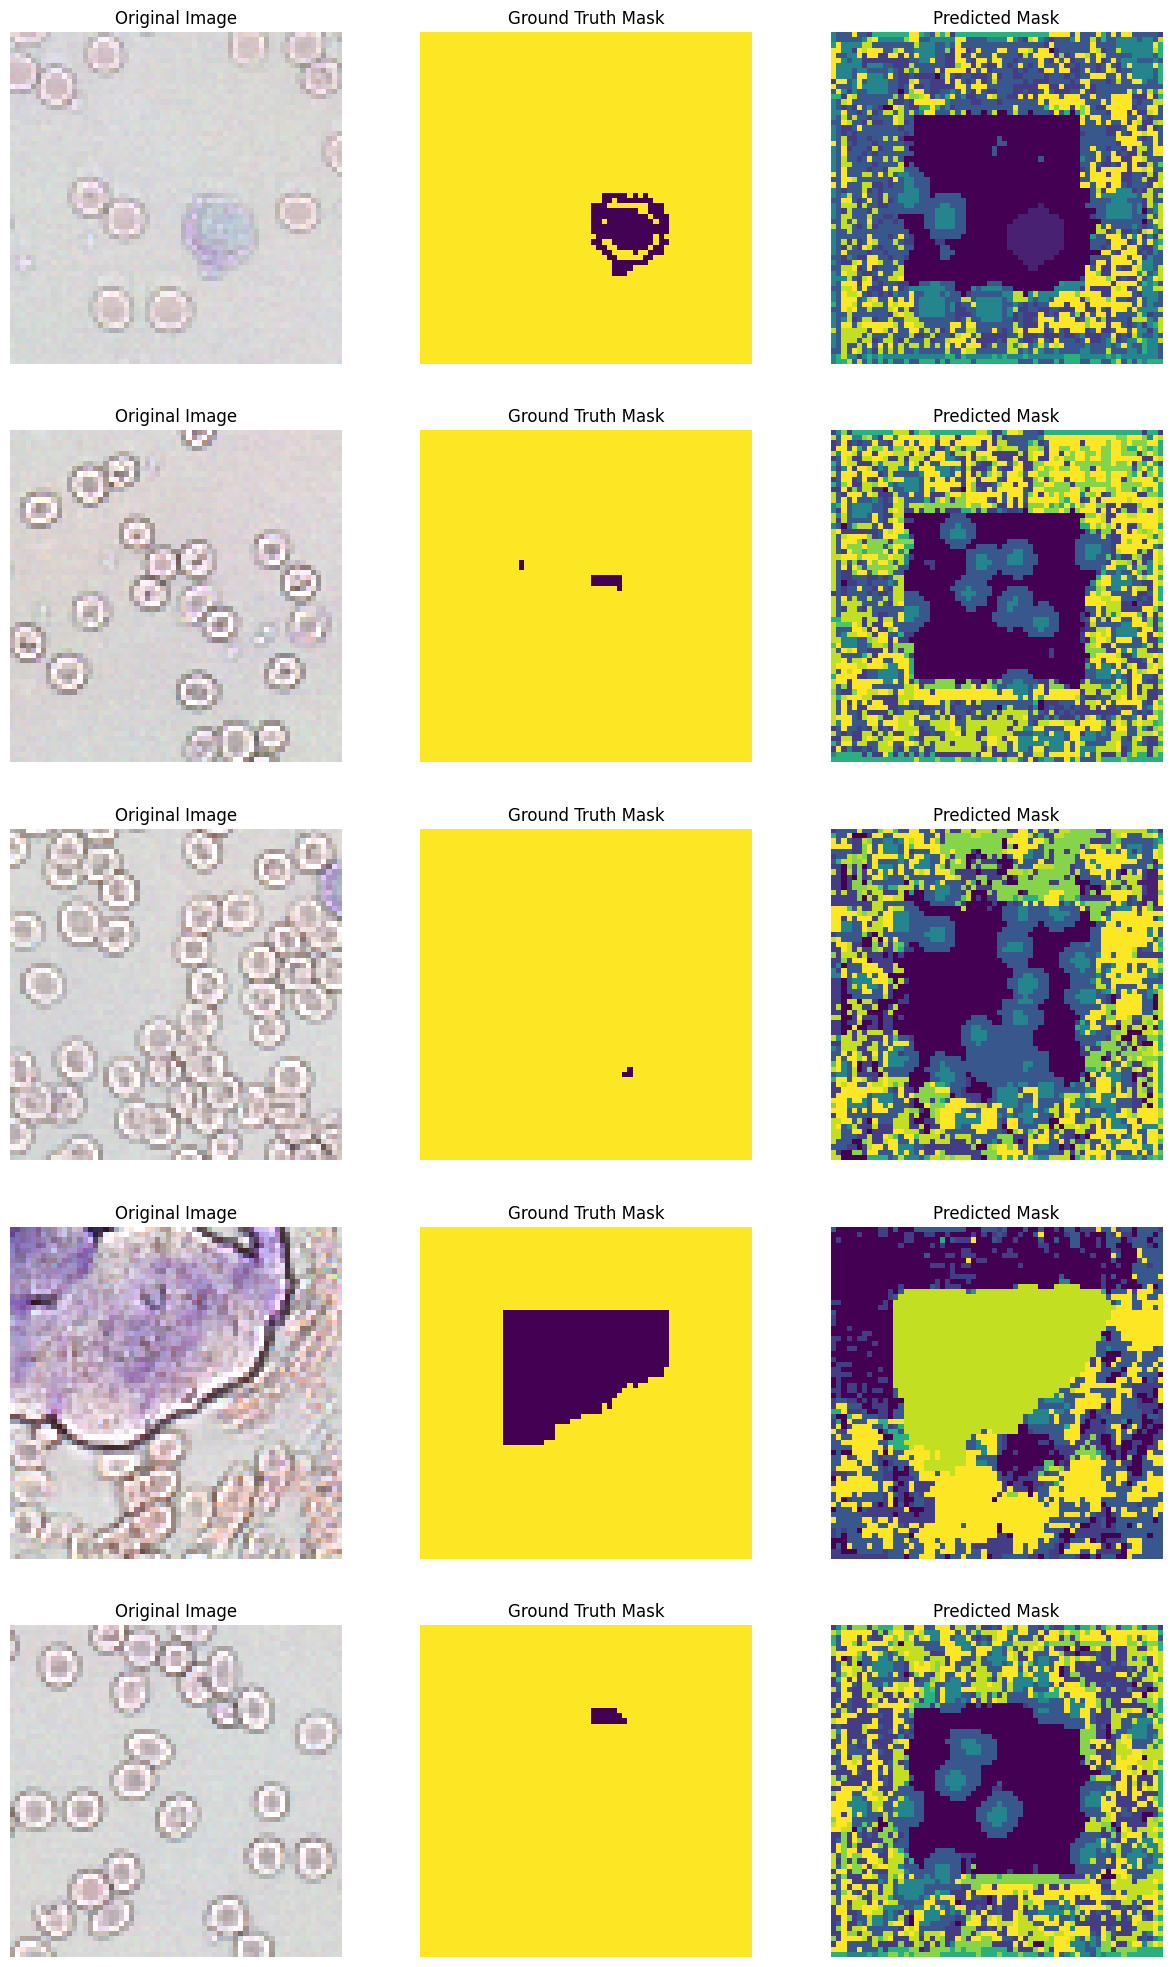

In [16]:
model.eval()
with torch.inference_mode():
    images, labels = next(iter(test_dataloader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    predictions = torch.argmax(outputs, dim=1)

    # Convert to numpy arrays for visualization
    images_np = images.cpu().numpy()
    labels_np = labels.cpu().numpy()
    predictions_np = predictions.cpu().numpy()
    print(
        f"Shape of image_np : {images_np.shape} | Label_np : {labels_np.shape} | Predictions : {predictions_np.shape}")
    # Visualize the predictions
    visualize_predictions(5, images_np, labels_np, predictions_np)
